In [103]:
import random
from datetime import datetime
import numpy
import pandas 

class TimeSeriesDataGenerator:
    def __init__(self, start_date, end_date, num_points):
        self.start_date = datetime.strptime(start_date, '%Y-%m-%d')
        self.end_date = datetime.strptime(end_date, '%Y-%m-%d')
        self.num_points = num_points
        self.data = self.generate_data()

    def generate_data(self):
        dates = []
        values = []
        delta = (self.end_date - self.start_date) / (self.num_points - 1)
        # Random trend: random value between -1 and 1
        trend = random.uniform(-1, 1)
        # Random seasonality: random period between num_points / 10 and num_points / 2
        seasonality_period = random.uniform(self.num_points / 10, self.num_points / 2)
        for i in range(self.num_points):
            date = self.start_date + i * delta
            # Trend: linearly increasing values
            trend_component = trend * i / self.num_points
            # Seasonality: sine wave with a random period
            seasonality_component = numpy.sin(2 * numpy.pi * i / seasonality_period)
            # Random noise
            noise = random.uniform(-0.2, 0.2)
            value = trend_component + seasonality_component + noise
            dates.append(date)
            values.append(value)
        values = [value if numpy.isfinite(value) else 0 for value in values] # Replace infinite and NaN values with a default value
        if not numpy.all(numpy.isfinite(values)):
            raise ValueError("Generated data contains infinite or NaN values")
        return pandas.Series(values, index=dates)

    def __len__(self):
        return len(self.data)

class GARCHTimeSeriesDataGenerator:
    def __init__(self, start_date, mu=0, omega=0.1, alpha=[0.5], beta=[0.5]):
        self.start_date = pandas.to_datetime(start_date)
        self.mu = mu
        self.omega = omega
        self.alpha = alpha
        self.beta = beta

    def simulate(self, n):
        # Initialize arrays
        errors = numpy.random.normal(size=n)
        sigmas = numpy.zeros_like(errors)
        returns = numpy.zeros_like(errors)

        # Simulate GARCH process
        for t in range(1, n):
            sigmas[t] = numpy.sqrt(self.omega + self.alpha[0] * errors[t-1]**2 + self.beta[0] * sigmas[t-1]**2)
            returns[t] = self.mu + sigmas[t] * errors[t]

        # Create date range
        dates = pandas.date_range(self.start_date, periods=n)

        # Create pandas Series
        simulated_series = pandas.Series(returns, index=dates)

        return simulated_series

In [104]:
og_data = TimeSeriesDataGenerator('2023-01-01', '2023-12-31', 1000).data
time_series_data = og_data
time_series_data

2023-01-01 00:00:00.000000    0.127745
2023-01-01 08:44:41.081081    0.122411
2023-01-01 17:29:22.162162   -0.024676
2023-01-02 02:14:03.243243    0.054243
2023-01-02 10:58:44.324324    0.103758
                                ...   
2023-12-29 13:01:15.675595    0.333172
2023-12-29 21:45:56.756676    0.412688
2023-12-30 06:30:37.837757    0.113636
2023-12-30 15:15:18.918838    0.301905
2023-12-30 23:59:59.999919    0.368737
Length: 1000, dtype: float64

In [105]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas
from pandas.plotting import lag_plot, autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_pacf


class TimeSeriesVisualizer:
    def __init__(self, time_series):
        self.time_series = time_series
        # Set the style of the plots to a professional one
        sns.set_style("whitegrid")
        # Set a consistend color palette
        sns_color_palette = sns.color_palette("bright", as_cmap=True)
        # Set a consistent color palette
        sns.set_palette(sns_color_palette)

    def scatter_plot(self):
        plt.figure(figsize=(10, 6))  # Set figure size
        df = self.time_series.reset_index()
        df.columns = ['date', 'value']
        sns.scatterplot(x='date', y='value', data=df)
        plt.title("Scatter Plot of Times Series Data")
        plt.xlabel("Date")
        plt.ylabel("Value")
        plt.xticks(rotation=45)  # Rotate x-axis labels
        plt.legend(bbox_to_anchor=(1.1, 1.05), title = 'Legend')
        plt.show()

    def line_plot(self, window_size=7, function='mean'):
        
        plt.figure(figsize=(10, 6))  # Set figure size
        df = self.time_series.reset_index()
        df.columns = ['date', 'value']
        sns.lineplot(x='date', y='value', data=df, label="Original Series")
        
        
        # Apply rolling window function
        if function == 'mean':
            df['rolling'] = df['value'].rolling(window_size).mean()
        elif function == 'sum':
            df['rolling'] = df['value'].rolling(window_size).sum()
        else:
            raise ValueError(f"Unsupported function: {function}. Supported functions are 'mean' and 'sum'.")
        sns.lineplot(x='date', y='rolling', data=df, label=f'Rolling {function} (window={window_size})')

        # Apply expanding window function
        # Note: expanding() does not take a window size
        if function == 'mean':
            df['expanding'] = df['value'].expanding().mean()
        elif function == 'sum':
            df['expanding'] = df['value'].expanding().sum()
        else:
            raise ValueError(f"Unsupported function: {function}. Supported functions are 'mean' and 'sum'.")
        sns.lineplot(x='date', y='expanding', data=df, label=f'Expanding {function}')

    
        sns.lineplot(x='date', y='rolling', data=df, label=f'Rolling {function} (window={window_size})')
        plt.title("Line Plot of Times Series Data")
        plt.xlabel("Date")
        plt.ylabel("Value")
        plt.xticks(rotation=45)  # Rotate x-axis labels
        plt.legend(bbox_to_anchor=(1.1, 1.05), title = 'Legend')
        plt.show()

    def histogram_plot(self):
        plt.figure(figsize=(10, 6))  # Set figure size
        sns.histplot(data=self.time_series)
        plt.title(f"Histogram Plot of Times Series Data")
        plt.xlabel("Date")
        plt.xticks(rotation=45)  # Rotate x-axis labels
        plt.legend(bbox_to_anchor=(1.1, 1.05), title = 'Legend')
        plt.show()
        
    def area_plot(self):
        plt.figure(figsize=(10, 6))
        if not hasattr(self.time_series, 'index'):
            self.time_series.index = pandas.RangeIndex(start=0, stop=len(self.time_series))
        plt.figure(figsize=(10, 6))
        plt.fill_between(self.time_series.index, self.time_series.values)
        plt.title("Area Plot of Time Series Data")
        plt.xlabel("Date")
        plt.ylabel("Value")
        plt.xticks(rotation=45)  # Rotate x-axis labels
        plt.legend(bbox_to_anchor=(1.1, 1.05), title = 'Legend')
        plt.show()

    def box_plot(self):
        plt.figure(figsize=(10, 6))
        sns.boxplot(data=self.time_series)
        plt.title("Box Plot of Time Series Data")
        plt.xlabel("Date")
        plt.ylabel("Value")
        plt.xticks(rotation=45)  # Rotate x-axis labels
        plt.legend(bbox_to_anchor=(1.1, 1.05), title = 'Legend')
        plt.show()

    def lag_plot(self, lag_time = 1):
        plt.figure(figsize=(10, 6))
        lag_plot(self.time_series, lag=lag_time)
        plt.title(f"Lag Plot of Time Series Data: Lag Time of {lag_time}")
        plt.legend(bbox_to_anchor=(1.1, 1.05), title = 'Legend')
        plt.show()

    def autocorrelation_plot(self):
        plt.figure(figsize=(10, 6))
        autocorrelation_plot(self.time_series)
        plt.title("Autocorrelation Plot of Time Series Data")

        # Calculate autocorrelation values starting from lag 1
        self._autocorr_values = [self.time_series.autocorr(lag=lag) for lag in range(1, len(self.time_series))]

        # Find highest and lowest autocorrelation values and their respective lag intervals
        max_autocorr = max(self._autocorr_values)
        min_autocorr = min(self._autocorr_values)
        max_lag = self._autocorr_values.index(max_autocorr) + 1  # Add 1 because we started from lag 1
        min_lag = self._autocorr_values.index(min_autocorr) + 1  # Add 1 because we started from lag 1

        # Add vertical lines to indicate lags with highest and lowest autocorrelation values
        plt.axvline(x=max_lag, color='r', linestyle='--')
        plt.axvline(x=min_lag, color='b', linestyle='--')

        # Display highest and lowest autocorrelation values in the legend
        plt.legend([f'Max: {max_autocorr:.2f} (Lag: {max_lag})', f'Min: {min_autocorr:.2f} (Lag: {min_lag})'], 
                title = 'Autocorrelation values', loc='upper right')

        plt.show()
        
    def partial_autocorrelation_plot(self):
        plt.figure(figsize=(10, 6))
        plot_pacf(self.time_series, lags = len(self.time_series) * .49)
        plt.title("Partial Autocorrelation Plot of Time Series Data")
        plt.show()
        
    def visualize_all(self):
        try:
            for method_name in dir(self):
                if method_name.endswith('_plot'):
                    method = getattr(self, method_name)
                    method()
        except SystemError as e: 
            print(f"There was an error in the {method_name} method: {e}")


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<Figure size 1000x600 with 0 Axes>

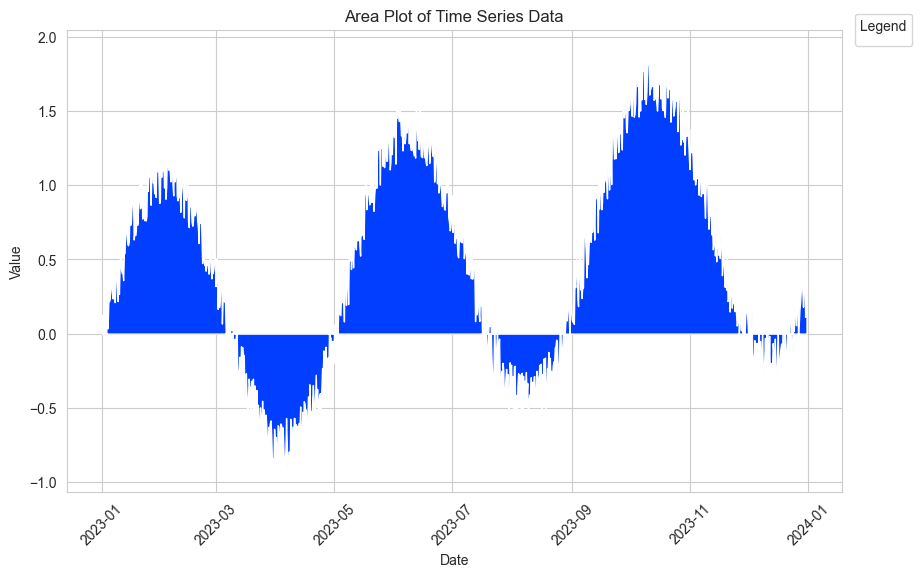

C:\Users\josep\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\numpy\lib\function_base.py:2889: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
C:\Users\josep\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\numpy\lib\function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
C:\Users\josep\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\numpy\lib\function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


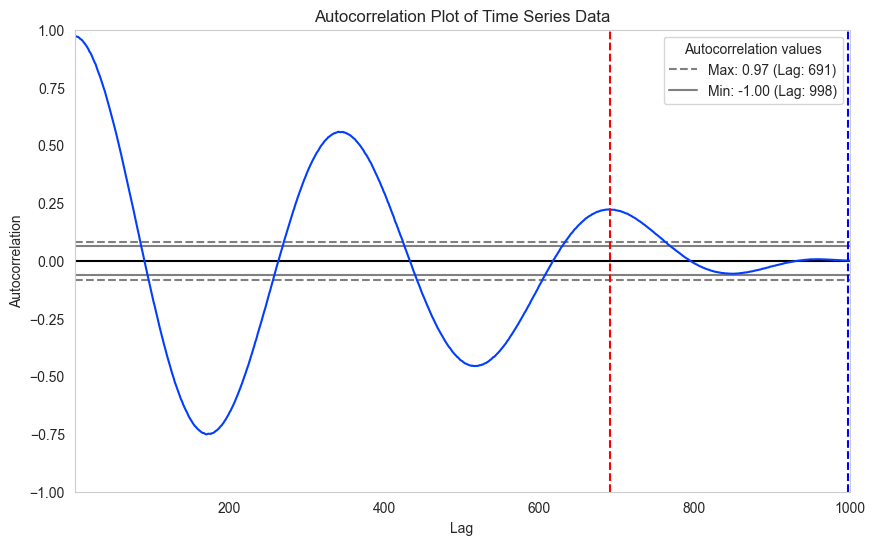

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


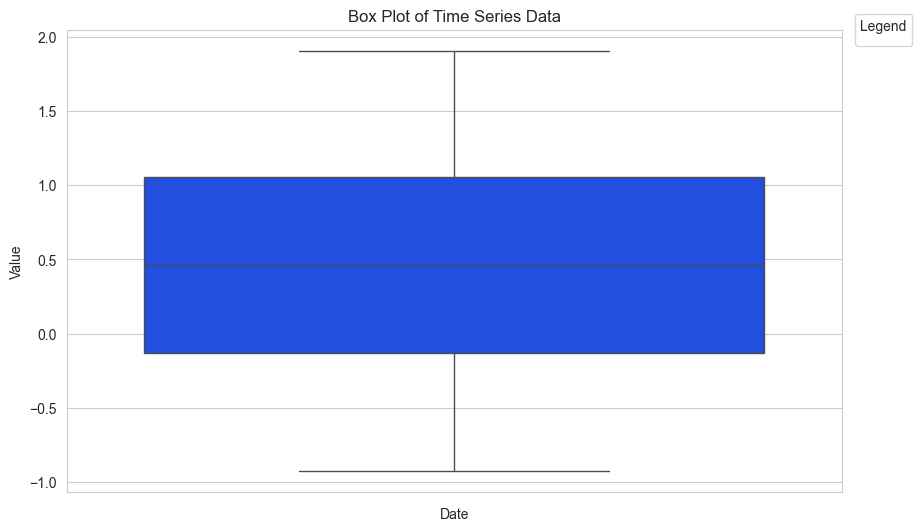

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


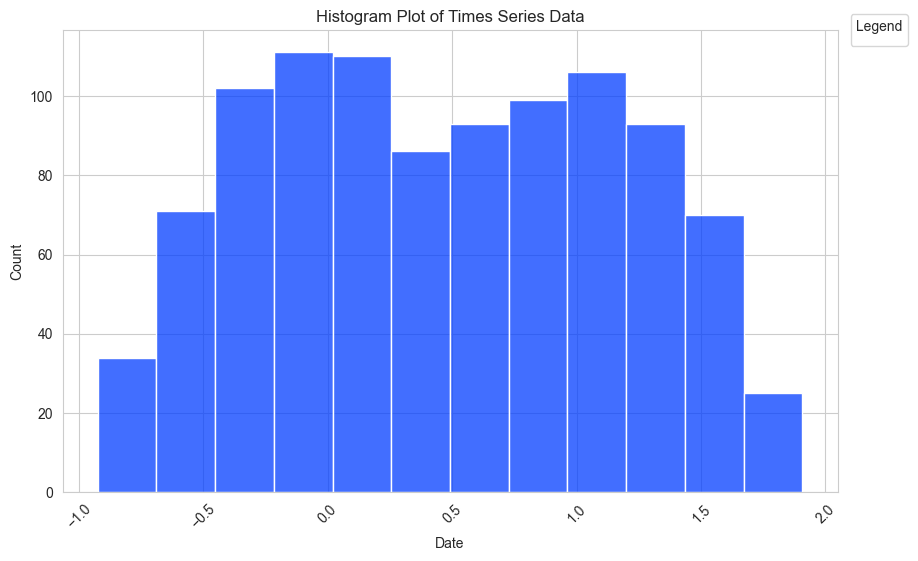

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


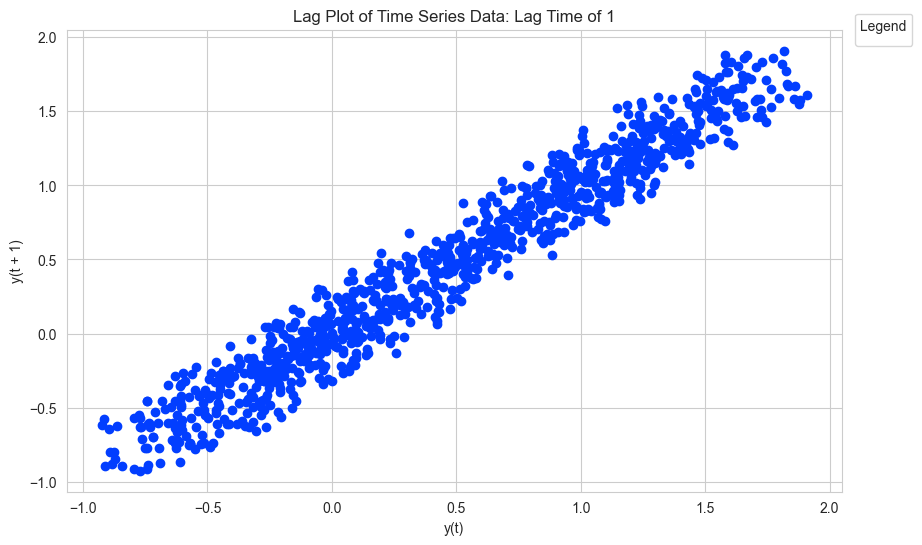

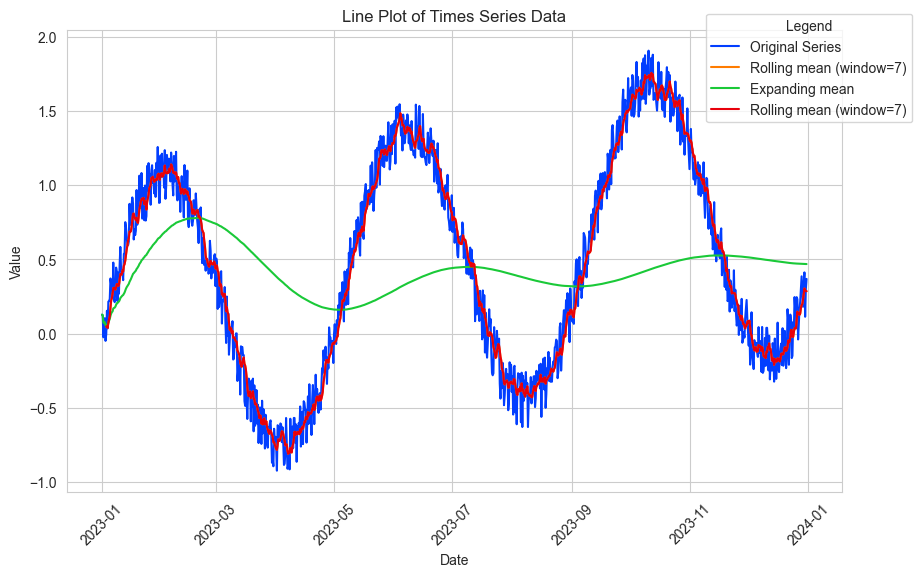

<Figure size 1000x600 with 0 Axes>

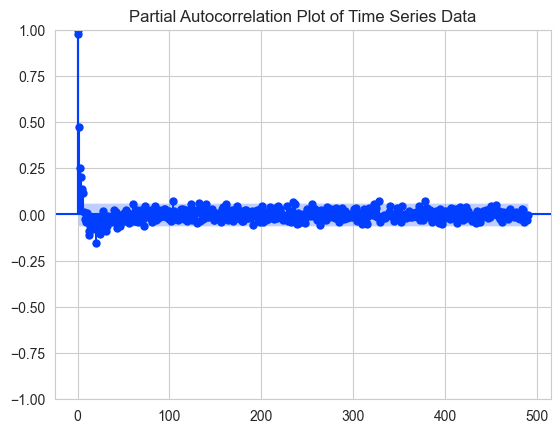

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


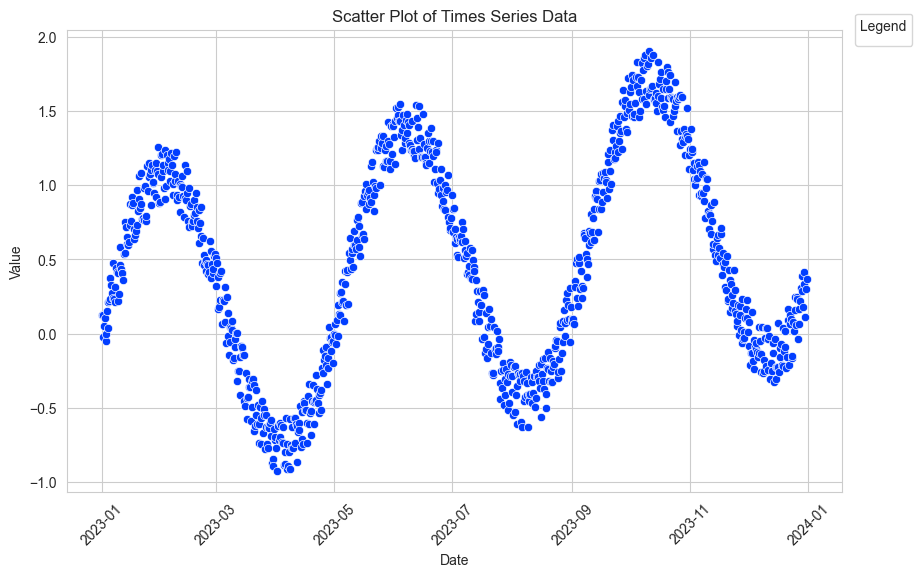

In [106]:
time_series_visualizer = TimeSeriesVisualizer(time_series_data)
time_series_visualizer.visualize_all()

In [107]:
from statsmodels.tsa.stattools import adfuller
import numpy as np

class StationarityTester:
    def __init__(self, time_series_generator):
        self.time_series = time_series_generator
        if not np.all(np.isfinite(self.time_series)):
            raise ValueError("Time series contains NaN or Inf values")

    def test_stationarity(self, timeseries, confidence_level=0.05):
        # Perform Dickey-Fuller test:
        print('Results of Dickey-Fuller Test:')
        dftest = adfuller(timeseries, autolag='AIC')
        dfoutput = pandas.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
        for key,value in dftest[4].items():
            dfoutput['Critical Value (%s)'%key] = value
        print(dfoutput)
        
        p_value = dfoutput['p-value']
        if p_value < confidence_level:
            print(f"--Your data is stationary, as the p-value ({p_value}) is less than your specified confidence level ({confidence_level}).")
        else:
            print(f"--Your data is not stationary, as the p-value ({p_value}) is greater than your specified confidence level ({confidence_level}).")
            
        return dfoutput['p-value']

    def make_stationary(self):
        print("---- Original Series Stationarity Test ----")
        p_value_original = self.test_stationarity(self.time_series)
        print(f"--Original series p-value: {p_value_original}")
        print("\n")
        
        # Shift the series to handle zero or negative values
        shift = abs(min(self.time_series)) + 1e-10
        adjusted_series = self.time_series + shift

        # Apply log transformation
        log_transformed = np.log(adjusted_series)
        print("---- Log Transformation Stationarity Test ----")
        p_value_log = self.test_stationarity(log_transformed)
        print(f"-- Log transformed series p-value: {p_value_log}")
        print("\nd")

        # Apply square root transformation
        sqrt_transformed = np.sqrt(adjusted_series)
        print("---- Square Root Transformation Stationarity Test ----")
        p_value_sqrt = self.test_stationarity(sqrt_transformed)
        print(f"-- Square root transformed series p-value: {p_value_sqrt}")
        print("\n")

        # Compare p-values and return the most stationary series
        if min(p_value_original, p_value_log, p_value_sqrt) == p_value_log:
            print("Log transformation resulted in the most stationary series. Returning the log transformed series.")
            log_transformed._transformed_series_type = 'log'
            return log_transformed
        elif min(p_value_original, p_value_log, p_value_sqrt) == p_value_sqrt:
            print("Square root transformation resulted in the most stationary series. Returning the square root transformed series.")
            sqrt_transformed._transformed_series_type = 'sqrt'
            return sqrt_transformed
        else:
            print("The original series is the most stationary.")
            self.time_series._transformed_series_type = 'original'
            return self.time_series

In [108]:
stationarity_tester = StationarityTester(time_series_data)
stationary_series = stationarity_tester.make_stationary()
print(f"\nSeries transformation type: {stationary_series._transformed_series_type}")

---- Original Series Stationarity Test ----
Results of Dickey-Fuller Test:
Test Statistic                  -2.673741
p-value                          0.078693
#Lags Used                      20.000000
Number of Observations Used    979.000000
Critical Value (1%)             -3.437047
Critical Value (5%)             -2.864497
Critical Value (10%)            -2.568344
dtype: float64
--Your data is not stationary, as the p-value (0.07869342706101379) is greater than your specified confidence level (0.05).
--Original series p-value: 0.07869342706101379


---- Log Transformation Stationarity Test ----
Results of Dickey-Fuller Test:
Test Statistic                  -1.641763
p-value                          0.461340
#Lags Used                      18.000000
Number of Observations Used    981.000000
Critical Value (1%)             -3.437033
Critical Value (5%)             -2.864491
Critical Value (10%)            -2.568341
dtype: float64
--Your data is not stationary, as the p-value (0.4613395

In [109]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# statistical models
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.statespace.kalman_filter import KalmanFilter
from statsmodels.tsa.statespace.structural import UnobservedComponents
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import STL
from arch import arch_model
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor




class TimeSeriesModel:
    def __init__(self, time_series_data):
        self.time_series_data = time_series_data
        self.train_data = time_series_data[:int(0.8*len(time_series_data))]
        self.test_data = time_series_data[int(0.8*len(time_series_data)):]
        self.exog = None # change this to account for any exogenous variables
        
        plt.title(f" of Times Series Data")
        plt.xticks(rotation=45)  # Rotate x-axis labels
        plt.legend(bbox_to_anchor=(1.1, 1.05), title = 'Legend')

    def arima(self, p=1, d=1, q=1):
        model = ARIMA(self.train_data, order=(p,d,q))
        model_fit = model.fit()
        forecast = model_fit.forecast(steps=len(self.test_data))
        mse = mean_squared_error(self.test_data, forecast)
        rmse = np.sqrt(mse)
        plt.figure(figsize=(10, 6))  # Set figure size
        plt.title(f"ARIMA Forecast Model of Times Series Data")
        plt.plot(self.time_series_data, label='Original Data')
        plt.plot(forecast, label='ARIMA Forecast')
        plt.legend()
        plt.show()
        return ('ARIMA', forecast, rmse)
    
    def sarimax(self, order=(1, 1, 1), seasonal_order=(0, 0, 0, 0)):
        model = SARIMAX(self.train_data, order=order, seasonal_order=seasonal_order, exog=self.exog)
        model_fit = model.fit(disp=False)
        forecast = model_fit.forecast(steps=len(self.test_data))
        mse = mean_squared_error(self.test_data, forecast)
        rmse = np.sqrt(mse)
        plt.figure(figsize=(10, 6))  # Set figure size
        plt.title(f"SARIMAX Forecast Model of Times Series Data")
        plt.plot(self.time_series_data, label='Original Data')
        plt.plot(forecast, label='SARIMAX Forecast')
        plt.legend()
        plt.show()
        return ('SARIMAX', forecast, rmse)


    def holt_winters(self, trend='add', seasonal='add', seasonal_periods=12):
        model = ExponentialSmoothing(self.train_data, trend=trend, seasonal=seasonal, seasonal_periods=seasonal_periods)
        model_fit = model.fit()
        forecast = model_fit.forecast(steps=len(self.test_data))
        mse = mean_squared_error(self.test_data, forecast)
        rmse = np.sqrt(mse)
        plt.figure(figsize=(10, 6))  # Set figure size
        plt.title(f"Holt-Winters Forecast Model of Times Series Data")
        plt.plot(self.time_series_data, label='Original Data')
        plt.plot(forecast, label='Holt-Winters Forecast')
        plt.legend()
        plt.show()
        return ('Holt-Winters', forecast, rmse)
    
    def stl(self, period=12):
        stl = STL(self.time_series_data, period=period)
        res = stl.fit()
        decomp = pd.DataFrame({
        'trend': res.trend,
        'seasonal': res.seasonal,
        'resid': res.resid
        })
        trend_model = ARIMA(decomp['trend'].dropna(), order=(1, 1, 1))
        trend_model_fit = trend_model.fit()
        trend_forecast = trend_model_fit.forecast(steps=len(self.test_data))
        seasonal_model = ARIMA(decomp['seasonal'].dropna(), order=(1, 1, 1))
        seasonal_model_fit = seasonal_model.fit()
        seasonal_forecast = seasonal_model_fit.forecast(steps=len(self.test_data))
        forecast = trend_forecast + seasonal_forecast
        mse = mean_squared_error(self.test_data, forecast)
        rmse = np.sqrt(mse)
        plt.figure(figsize=(10, 6))  # Set figure size
        plt.title(f"STL + ARIMA Forecast Model of Times Series Data")
        plt.plot(self.time_series_data, label='Original Data')
        plt.plot(forecast, label='STL + ARIMA Forecast')
        plt.legend()
        plt.show()
        return ('STL + ARIMA', forecast, rmse)
    
    def garch(self, p=1, q=1):
        model = arch_model(self.time_series_data, vol='GARCH', p=p, q=q)
        model_fit = model.fit()
        forecast = model_fit.forecast(horizon=len(self.test_data))
        forecast = forecast.variance.values[-1, :]
        forecast = np.sqrt(forecast)
        mse = mean_squared_error(self.test_data, forecast)
        rmse = np.sqrt(mse)
        plt.figure(figsize=(10, 6))  # Set figure size
        plt.title(f"GARCH Forecast Model of Times Series Data")
        plt.plot(self.time_series_data, label='Original Data')
        plt.plot(forecast, label='GARCH Forecast')
        plt.legend()
        plt.show()
        return ('GARCH', forecast, rmse)
    
    def kalman_filter(self):
        kf = KalmanFilter(k_endog=1, k_states=1)
        kf.initialize_approximate_diffuse()
        measurements = np.asarray(self.train_data).reshape(-1, 1)
        kf.bind(measurements)
        filter_results = kf.filter()
        forecast = filter_results.filtered_state[-1]
        if len(forecast) > len(self.test_data):
            forecast = forecast[:len(self.test_data)]
        elif len(forecast) < len(self.test_data):
            forecast = np.concatenate((forecast, [forecast[-1]] * (len(self.test_data) - len(forecast))))
        mse = mean_squared_error(self.test_data, forecast)
        rmse = np.sqrt(mse)
        plt.figure(figsize=(10, 6))  # Set figure size
        plt.title(f"Kalman Filter Forecast Model of Times Series Data")
        plt.plot(self.time_series_data, label='Original Data')
        plt.plot(forecast, label='Kalman Filter Forecast')
        plt.legend()
        plt.show()
        return ('Kalman Filter', forecast, rmse)
    
    def unobserved_components(self):
        uc = UnobservedComponents(self.time_series_data, 'local level')
        uc_fit = uc.fit()
        forecast = uc_fit.forecast(steps=len(self.test_data))
        mse = mean_squared_error(self.test_data, forecast)
        rmse = np.sqrt(mse)
        plt.figure(figsize=(10, 6))  # Set figure size
        plt.title(f"Unobserved Components Forecast Model of Times Series Data")
        plt.plot(self.time_series_data, label='Original Data')
        plt.plot(forecast, label='Unobserved Components Forecast')
        plt.legend()
        plt.show()
        return ('Unobserved Components', forecast, rmse)
    
    def random_forest_regressor(self, n_estimators=100):
        model = RandomForestRegressor(n_estimators=n_estimators)
        model.fit(np.arange(len(self.train_data)).reshape(-1, 1), self.train_data.values.reshape(-1, 1))
        forecast = model.predict(np.arange(len(self.train_data), len(self.time_series_data)).reshape(-1, 1))
        mse = mean_squared_error(self.test_data, forecast)
        rmse = np.sqrt(mse)
        plt.figure(figsize=(10, 6))  # Set figure size
        plt.title(f"Random Forest Regressor Forecast Model of Times Series Data")
        plt.plot(self.time_series_data, label='Original Data')
        plt.plot(range(len(self.train_data), len(self.time_series_data)), forecast, label='Random Forest Regressor Forecast')
        plt.legend()
        plt.show()
        return ('Random Forest Regressor', forecast, rmse)
        
    
    def gradient_boosting_regressor(self, n_estimators=100, learning_rate=0.1, max_depth=3, random_state=0, loss='ls'):
        model = GradientBoostingRegressor(n_estimators=n_estimators, learning_rate=learning_rate, max_depth=max_depth, random_state=random_state, loss=loss)
        model.fit(np.arange(len(self.train_data)).reshape(-1, 1), self.train_data)
        forecast = model.predict(np.arange(len(self.train_data), len(self.time_series_data)).reshape(-1, 1))
        mse = mean_squared_error(self.test_data, forecast)
        rmse = np.sqrt(mse)
        plt.figure(figsize=(10, 6))  # Set figure size
        plt.title(f"Gradient Boosting Regressor Forecast Model of Times Series Data")
        plt.plot(self.time_series_data, label='Original Data')
        plt.plot(range(len(self.train_data), len(self.time_series_data)), forecast, label='Gradient Boosting Regressor Forecast')
        plt.legend()
        plt.show()
        return ('Gradient Boosting Regressor', forecast, rmse)
    
    def xgboost_regressor(self, n_estimators=100, learning_rate=0.1, max_depth=3):
        model = XGBRegressor(n_estimators=n_estimators, learning_rate=learning_rate, max_depth=max_depth)
        model.fit(np.arange(len(self.train_data)).reshape(-1, 1), self.train_data)
        forecast = model.predict(np.arange(len(self.train_data), len(self.time_series_data)).reshape(-1, 1))
        mse = mean_squared_error(self.test_data, forecast)
        rmse = np.sqrt(mse)
        plt.figure(figsize=(10, 6))  # Set figure size
        plt.title(f"XGBoost Regressor Forecast Model of Times Series Data")
        plt.plot(self.time_series_data, label='Original Data')
        plt.plot(range(len(self.train_data), len(self.time_series_data)), forecast, label='XGBoost Regressor Forecast')
        plt.legend()
        plt.show()
        return ('XGBoost Regressor', forecast, rmse)
    
    def lightgbm_regressor(self, n_estimators=100, learning_rate=0.1, max_depth=-1):
        model = LGBMRegressor(n_estimators=n_estimators, learning_rate=learning_rate, max_depth=max_depth)
        model.fit(np.arange(len(self.train_data)).reshape(-1, 1), self.train_data)
        forecast = model.predict(np.arange(len(self.train_data), len(self.time_series_data)).reshape(-1, 1))
        mse = mean_squared_error(self.test_data, forecast)
        rmse = np.sqrt(mse)
        plt.figure(figsize=(10, 6))  # Set figure size
        plt.title(f"LightGBM Regressor Forecast Model of Times Series Data")
        plt.plot(self.time_series_data, label='Original Data')
        plt.plot(range(len(self.train_data), len(self.time_series_data)), forecast, label='LightGBM Regressor Forecast')
        plt.legend()
        plt.show()
        return ('LightGBM Regressor', forecast, rmse)
    
    def compare_models(self):
        models = [self.arima(), self.sarimax(), self.holt_winters(), self.stl(), self.garch(), self.kalman_filter(), self.unobserved_components(), self.random_forest_regressor(), self.xgboost_regressor(), self.lightgbm_regressor()]
        best_model = min(models, key=lambda x: x[2])
        print(f"Best performing model: {best_model[0]}")
        print(f"RMSE: {best_model[2]}")
        return best_model


In [112]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# statistical models
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.statespace.kalman_filter import KalmanFilter
from statsmodels.tsa.statespace.structural import UnobservedComponents
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import STL
from arch import arch_model
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor




class TimeSeriesModel:
    def __init__(self, time_series_data):
        self.time_series_data = time_series_data
        self.train_data = time_series_data[:int(0.8*len(time_series_data))]
        self.test_data = time_series_data[int(0.8*len(time_series_data)):]
        self.exog = None # change this to account for any exogenous variables
        

    def arima(self, p=1, d=1, q=1):
        model = ARIMA(self.train_data, order=(p,d,q))
        model_fit = model.fit()
        forecast = model_fit.forecast(steps=len(self.test_data))
        mse = mean_squared_error(self.test_data, forecast)
        rmse = np.sqrt(mse)
        plt.figure(figsize=(10, 6))  # Set figure size
        plt.title(f"ARIMA Forecast Model of Times Series Data")
        plt.plot(self.time_series_data, label='Original Data')
        plt.plot(forecast, label='ARIMA Forecast')
        plt.xticks(rotation=45)  # Rotate x-axis labels
        plt.legend(bbox_to_anchor=(1.1, 1.05), title = 'Legend')
        plt.show()
        return ('ARIMA', forecast, rmse)
    
    def sarimax(self, order=(1, 1, 1), seasonal_order=(0, 0, 0, 0)):
        model = SARIMAX(self.train_data, order=order, seasonal_order=seasonal_order, exog=self.exog)
        model_fit = model.fit(disp=False)
        forecast = model_fit.forecast(steps=len(self.test_data))
        mse = mean_squared_error(self.test_data, forecast)
        rmse = np.sqrt(mse)
        plt.figure(figsize=(10, 6))  # Set figure size
        plt.title(f"SARIMAX Forecast Model of Times Series Data")
        plt.plot(self.time_series_data, label='Original Data')
        plt.plot(forecast, label='SARIMAX Forecast')
        plt.xticks(rotation=45)  # Rotate x-axis labels
        plt.legend(bbox_to_anchor=(1.1, 1.05), title = 'Legend')
        plt.show()
        return ('SARIMAX', forecast, rmse)


    def holt_winters(self, trend='add', seasonal='add', seasonal_periods=12):
        model = ExponentialSmoothing(self.train_data, trend=trend, seasonal=seasonal, seasonal_periods=seasonal_periods)
        model_fit = model.fit()
        forecast = model_fit.forecast(steps=len(self.test_data))
        mse = mean_squared_error(self.test_data, forecast)
        rmse = np.sqrt(mse)
        plt.figure(figsize=(10, 6))  # Set figure size
        plt.title(f"Holt-Winters Forecast Model of Times Series Data")
        plt.plot(self.time_series_data, label='Original Data')
        plt.plot(forecast, label='Holt-Winters Forecast')
        plt.xticks(rotation=45)  # Rotate x-axis labels
        plt.legend(bbox_to_anchor=(1.1, 1.05), title = 'Legend')
        plt.show()
        return ('Holt-Winters', forecast, rmse)
    
    def stl(self, period=12):
        stl = STL(self.time_series_data, period=period)
        res = stl.fit()
        decomp = pd.DataFrame({
        'trend': res.trend,
        'seasonal': res.seasonal,
        'resid': res.resid
        })
        trend_model = ARIMA(decomp['trend'].dropna(), order=(1, 1, 1))
        trend_model_fit = trend_model.fit()
        trend_forecast = trend_model_fit.forecast(steps=len(self.test_data))
        seasonal_model = ARIMA(decomp['seasonal'].dropna(), order=(1, 1, 1))
        seasonal_model_fit = seasonal_model.fit()
        seasonal_forecast = seasonal_model_fit.forecast(steps=len(self.test_data))
        forecast = trend_forecast + seasonal_forecast
        mse = mean_squared_error(self.test_data, forecast)
        rmse = np.sqrt(mse)
        plt.figure(figsize=(10, 6))  # Set figure size
        plt.title(f"STL + ARIMA Forecast Model of Times Series Data")
        plt.plot(self.time_series_data, label='Original Data')
        plt.plot(forecast, label='STL + ARIMA Forecast')
        plt.xticks(rotation=45)  # Rotate x-axis labels
        plt.legend(bbox_to_anchor=(1.1, 1.05), title = 'Legend')
        plt.show()
        return ('STL + ARIMA', forecast, rmse)
    
    def garch(self, p=1, q=1):
        model = arch_model(self.time_series_data, vol='GARCH', p=p, q=q)
        model_fit = model.fit()
        forecast = model_fit.forecast(horizon=len(self.test_data))
        forecast = forecast.variance.values[-1, :]
        forecast = np.sqrt(forecast)
        mse = mean_squared_error(self.test_data, forecast)
        rmse = np.sqrt(mse)
        plt.figure(figsize=(10, 6))  # Set figure size
        plt.title(f"GARCH Forecast Model of Times Series Data")
        plt.plot(self.time_series_data, label='Original Data')
        plt.plot(forecast, label='GARCH Forecast')
        plt.xticks(rotation=45)  # Rotate x-axis labels
        plt.legend(bbox_to_anchor=(1.1, 1.05), title = 'Legend')
        plt.show()
        return ('GARCH', forecast, rmse)
    
    def kalman_filter(self):
        kf = KalmanFilter(k_endog=1, k_states=1)
        kf.initialize_approximate_diffuse()
        measurements = np.asarray(self.train_data).reshape(-1, 1)
        kf.bind(measurements)
        filter_results = kf.filter()
        forecast = filter_results.filtered_state[-1]
        if len(forecast) > len(self.test_data):
            forecast = forecast[:len(self.test_data)]
        elif len(forecast) < len(self.test_data):
            forecast = np.concatenate((forecast, [forecast[-1]] * (len(self.test_data) - len(forecast))))
        mse = mean_squared_error(self.test_data, forecast)
        rmse = np.sqrt(mse)
        plt.figure(figsize=(10, 6))  # Set figure size
        plt.title(f"Kalman Filter Forecast Model of Times Series Data")
        plt.plot(self.time_series_data, label='Original Data')
        plt.plot(forecast, label='Kalman Filter Forecast')
        plt.xticks(rotation=45)  # Rotate x-axis labels
        plt.legend(bbox_to_anchor=(1.1, 1.05), title = 'Legend')
        plt.show()
        return ('Kalman Filter', forecast, rmse)
    
    def unobserved_components(self):
        uc = UnobservedComponents(self.time_series_data, 'local level')
        uc_fit = uc.fit()
        forecast = uc_fit.forecast(steps=len(self.test_data))
        mse = mean_squared_error(self.test_data, forecast)
        rmse = np.sqrt(mse)
        plt.figure(figsize=(10, 6))  # Set figure size
        plt.title(f"Unobserved Components Forecast Model of Times Series Data")
        plt.plot(self.time_series_data, label='Original Data')
        plt.plot(forecast, label='Unobserved Components Forecast')
        plt.xticks(rotation=45)  # Rotate x-axis labels
        plt.legend(bbox_to_anchor=(1.1, 1.05), title = 'Legend')
        plt.show()
        return ('Unobserved Components', forecast, rmse)
    
    def random_forest_regressor(self, n_estimators=100):
        model = RandomForestRegressor(n_estimators=n_estimators)
        model.fit(np.arange(len(self.train_data)).reshape(-1, 1), self.train_data.values.reshape(-1, 1))
        forecast = model.predict(np.arange(len(self.train_data), len(self.time_series_data)).reshape(-1, 1))
        mse = mean_squared_error(self.test_data, forecast)
        rmse = np.sqrt(mse)
        plt.figure(figsize=(10, 6))  # Set figure size
        plt.title(f"Random Forest Regressor Forecast Model of Times Series Data")
        plt.plot(self.time_series_data, label='Original Data')
        plt.plot(range(len(self.train_data), len(self.time_series_data)), forecast, label='Random Forest Regressor Forecast')
        plt.xticks(rotation=45)  # Rotate x-axis labels
        plt.legend(bbox_to_anchor=(1.1, 1.05), title = 'Legend')
        plt.show()
        return ('Random Forest Regressor', forecast, rmse)
        
    
    def gradient_boosting_regressor(self, n_estimators=100, learning_rate=0.1, max_depth=3, random_state=0, loss='ls'):
        model = GradientBoostingRegressor(n_estimators=n_estimators, learning_rate=learning_rate, max_depth=max_depth, random_state=random_state, loss=loss)
        model.fit(np.arange(len(self.train_data)).reshape(-1, 1), self.train_data)
        forecast = model.predict(np.arange(len(self.train_data), len(self.time_series_data)).reshape(-1, 1))
        mse = mean_squared_error(self.test_data, forecast)
        rmse = np.sqrt(mse)
        plt.figure(figsize=(10, 6))  # Set figure size
        plt.plot(self.time_series_data, label='Original Data')
        plt.title(f"Gradient Boosting Regressor Forecast Model of Times Series Data")
        plt.plot(range(len(self.train_data), len(self.time_series_data)), forecast, label='Gradient Boosting Regressor Forecast')
        plt.xticks(rotation=45)  # Rotate x-axis labels
        plt.legend(bbox_to_anchor=(1.1, 1.05), title = 'Legend')
        plt.show()
        return ('Gradient Boosting Regressor', forecast, rmse)
    
    def xgboost_regressor(self, n_estimators=100, learning_rate=0.1, max_depth=3):
        model = XGBRegressor(n_estimators=n_estimators, learning_rate=learning_rate, max_depth=max_depth)
        model.fit(np.arange(len(self.train_data)).reshape(-1, 1), self.train_data)
        forecast = model.predict(np.arange(len(self.train_data), len(self.time_series_data)).reshape(-1, 1))
        mse = mean_squared_error(self.test_data, forecast)
        rmse = np.sqrt(mse)
        plt.figure(figsize=(10, 6))  # Set figure size
        plt.title(f"XGBoost Regressor Forecast Model of Times Series Data")
        plt.plot(self.time_series_data, label='Original Data')
        plt.plot(range(len(self.train_data), len(self.time_series_data)), forecast, label='XGBoost Regressor Forecast')
        plt.xticks(rotation=45)  # Rotate x-axis labels
        plt.legend(bbox_to_anchor=(1.1, 1.05), title = 'Legend')
        plt.show()
        return ('XGBoost Regressor', forecast, rmse)
    
    def lightgbm_regressor(self, n_estimators=100, learning_rate=0.1, max_depth=-1):
        model = LGBMRegressor(n_estimators=n_estimators, learning_rate=learning_rate, max_depth=max_depth)
        model.fit(np.arange(len(self.train_data)).reshape(-1, 1), self.train_data)
        forecast = model.predict(np.arange(len(self.train_data), len(self.time_series_data)).reshape(-1, 1))
        mse = mean_squared_error(self.test_data, forecast)
        rmse = np.sqrt(mse)
        plt.figure(figsize=(10, 6))  # Set figure size
        plt.title(f"LightGBM Regressor Forecast Model of Times Series Data")
        plt.plot(self.time_series_data, label='Original Data')
        plt.plot(range(len(self.train_data), len(self.time_series_data)), forecast, label='LightGBM Regressor Forecast')
        plt.xticks(rotation=45)  # Rotate x-axis labels
        plt.legend(bbox_to_anchor=(1.1, 1.05), title = 'Legend')
        plt.show()
        return ('LightGBM Regressor', forecast, rmse)
    
    def compare_models(self):
        models = [self.arima(), self.sarimax(), self.holt_winters(), self.stl(), self.garch(), self.kalman_filter(), self.unobserved_components(), self.random_forest_regressor(), self.xgboost_regressor(), self.lightgbm_regressor()]
        best_model = min(models, key=lambda x: x[2])
        print(f"Best performing model: {best_model[0]}")
        print(f"RMSE: {best_model[2]}")
        return best_model


C:\Users\josep\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 31481081081U will be used.
  self._init_dates(dates, freq)
C:\Users\josep\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 31481081081U will be used.
  self._init_dates(dates, freq)
C:\Users\josep\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 31481081081U will be used.
  self._init_dates(dates, freq)


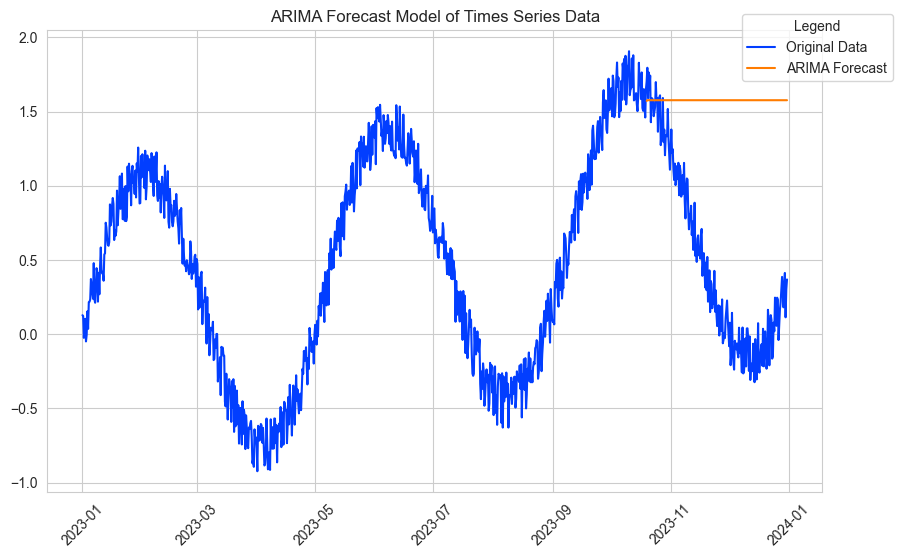

C:\Users\josep\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 31481081081U will be used.
  self._init_dates(dates, freq)
C:\Users\josep\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 31481081081U will be used.
  self._init_dates(dates, freq)


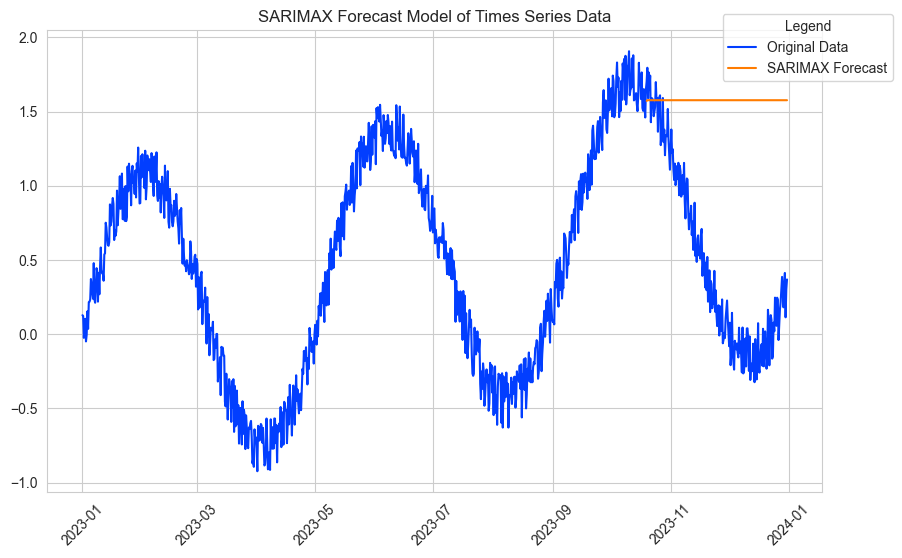

C:\Users\josep\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 31481081081U will be used.
  self._init_dates(dates, freq)


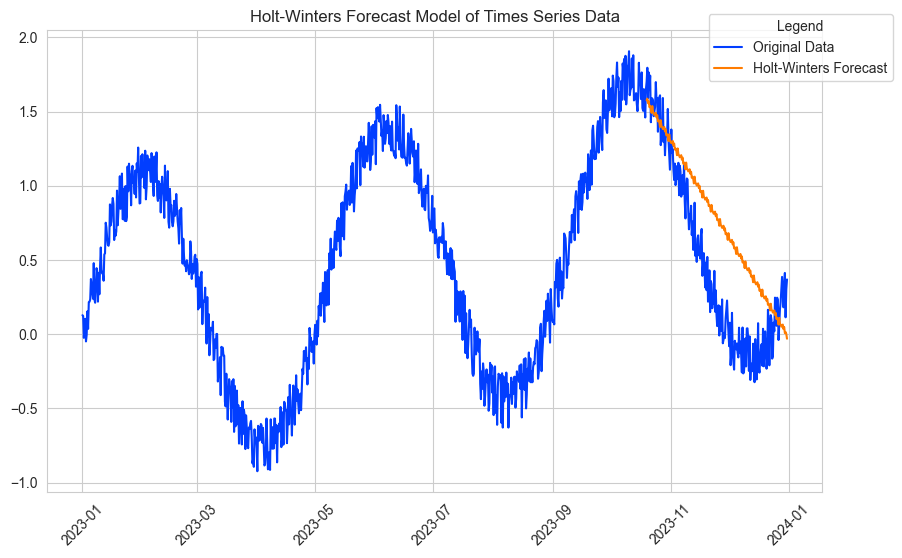

C:\Users\josep\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 31481081081U will be used.
  self._init_dates(dates, freq)
C:\Users\josep\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 31481081081U will be used.
  self._init_dates(dates, freq)
C:\Users\josep\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 31481081081U will be used.
  self._init_dates(dates, freq)
C:\Users\josep\AppData\Local\Packages\PythonSoftwareFoundation.P

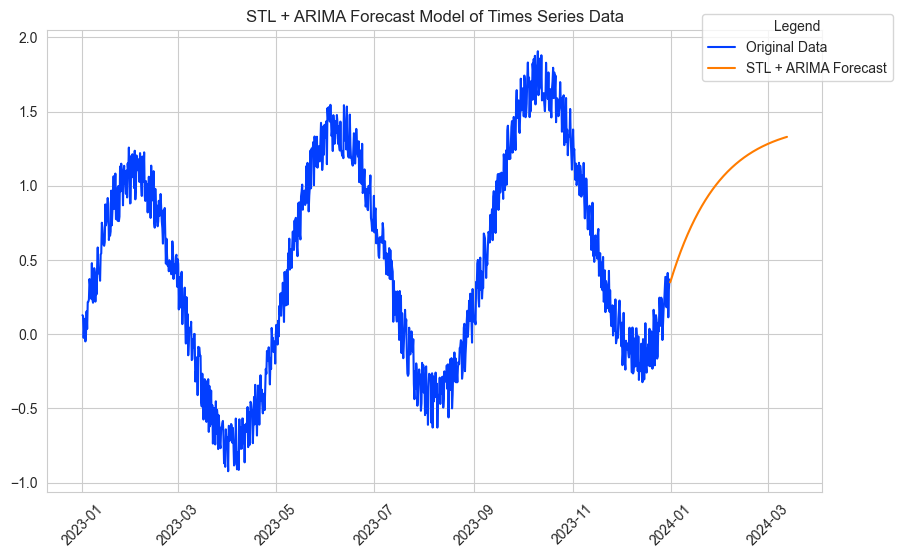

Iteration:      1,   Func. Count:      6,   Neg. LLF: 2322041508.943529
Iteration:      2,   Func. Count:     14,   Neg. LLF: 1867627329.438874
Iteration:      3,   Func. Count:     21,   Neg. LLF: 9491.814008740826
Iteration:      4,   Func. Count:     27,   Neg. LLF: 797.1806751942174
Iteration:      5,   Func. Count:     33,   Neg. LLF: 787.8784105129894
Iteration:      6,   Func. Count:     39,   Neg. LLF: 793.4512377662691
Iteration:      7,   Func. Count:     45,   Neg. LLF: 789.7149723899076
Iteration:      8,   Func. Count:     51,   Neg. LLF: 782.848133560903
Iteration:      9,   Func. Count:     57,   Neg. LLF: 972.0253011331885
Iteration:     10,   Func. Count:     65,   Neg. LLF: 788.6325000537245
Iteration:     11,   Func. Count:     71,   Neg. LLF: 777.6044428641727
Iteration:     12,   Func. Count:     76,   Neg. LLF: 777.5926639998955
Iteration:     13,   Func. Count:     81,   Neg. LLF: 777.5922195741749
Iteration:     14,   Func. Count:     86,   Neg. LLF: 777.5921938

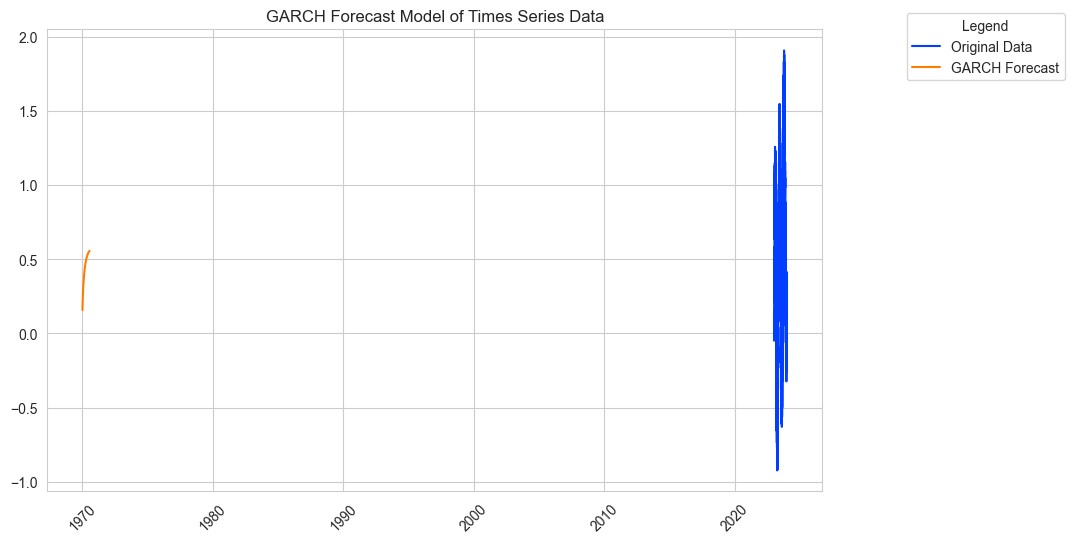

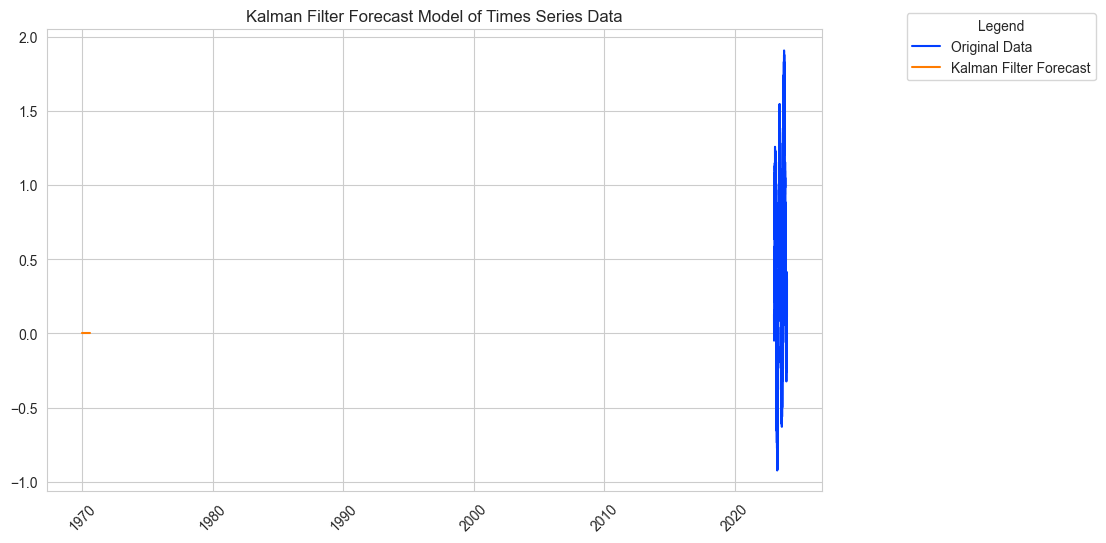

C:\Users\josep\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 31481081081U will be used.
  self._init_dates(dates, freq)


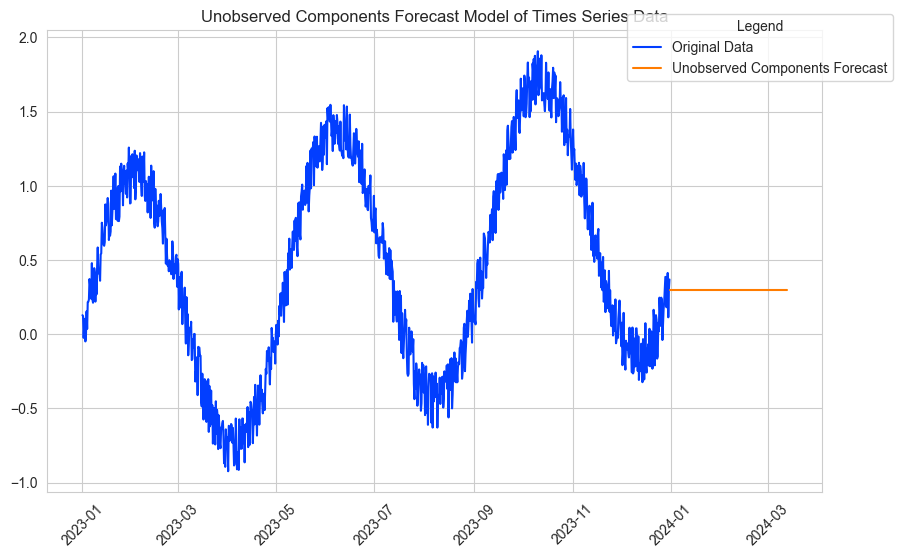

C:\Users\josep\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


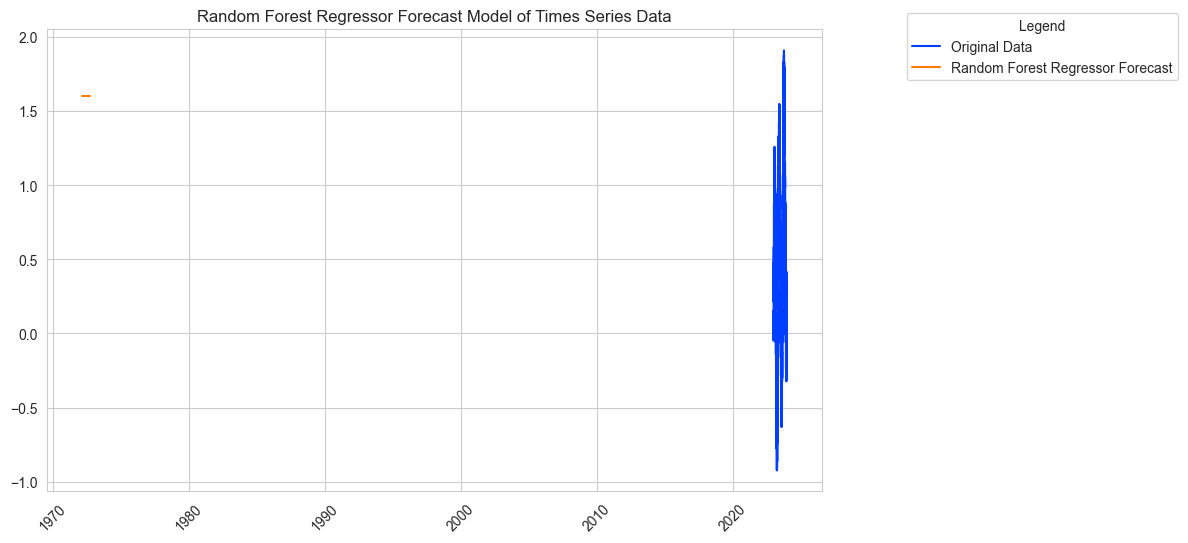

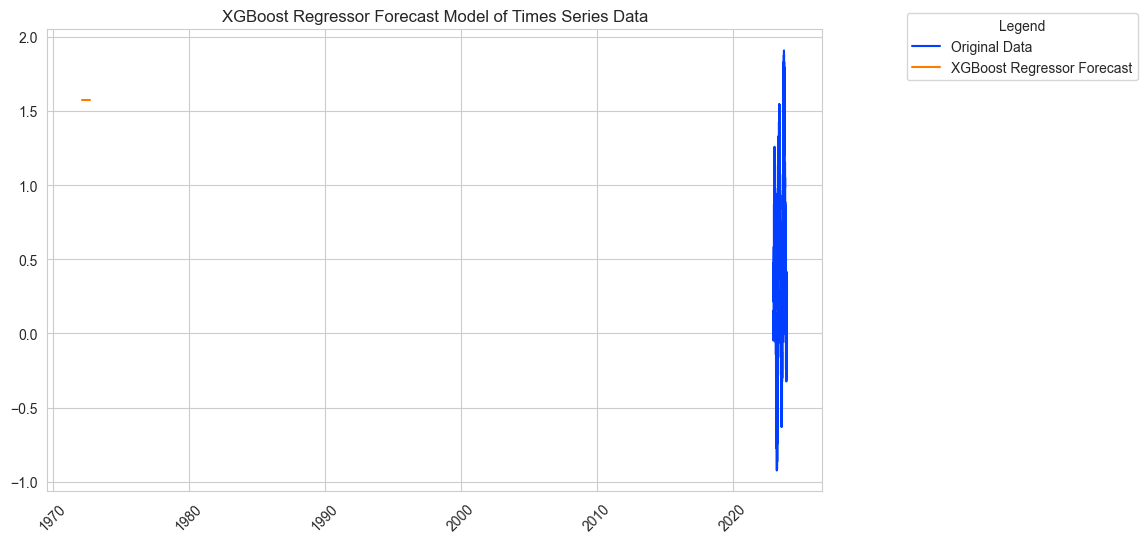

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000031 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 800, number of used features: 1
[LightGBM] [Info] Start training from score 0.465968
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

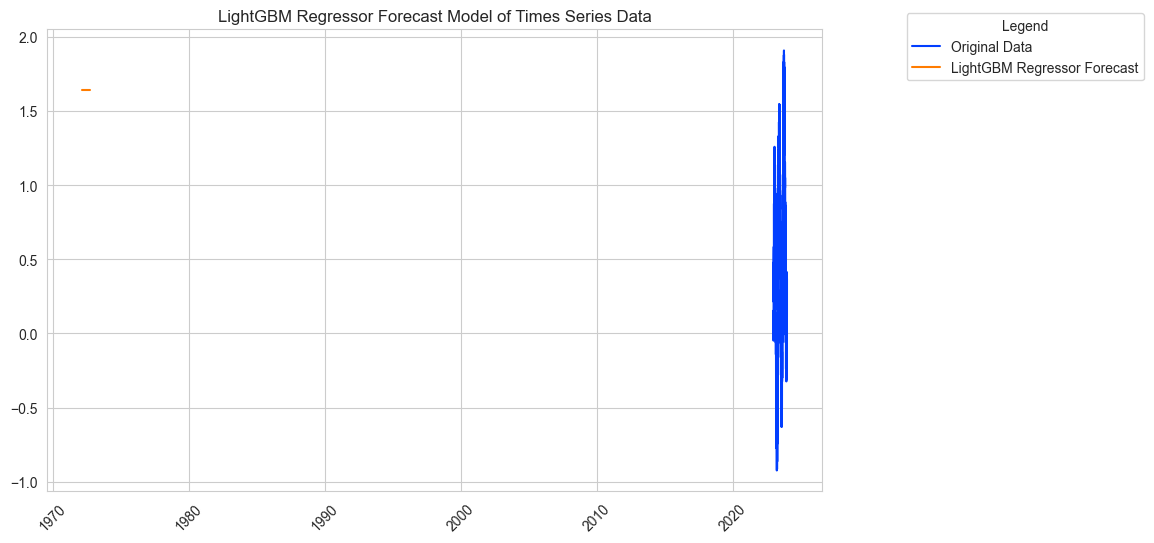

Best performing model: Holt-Winters
RMSE: 0.43263907247808325


('Holt-Winters',
 2023-10-19 11:47:44.864800    1.577133
 2023-10-19 20:32:25.945881    1.587418
 2023-10-20 05:17:07.026962    1.556779
 2023-10-20 14:01:48.108043    1.571023
 2023-10-20 22:46:29.189124    1.529998
                                 ...   
 2023-12-29 13:01:15.675595    0.048367
 2023-12-29 21:45:56.756676    0.007342
 2023-12-30 06:30:37.837757    0.014280
 2023-12-30 15:15:18.918838    0.001281
 2023-12-30 23:59:59.999919   -0.030540
 Freq: 31481081081U, Length: 200, dtype: float64,
 0.43263907247808325)

In [113]:
# create an instance of the TimeSeriesModel class
model = TimeSeriesModel(stationary_series)

# call the arima method with default parameters
#model.arima()

# call the sarimax method with custom parameters
#model.sarimax()

# call the holt_winters method with custom parameters
#model.holt_winters(trend='add', seasonal='add', seasonal_periods=12)

# call the stl method with custom parameters
#model.stl()

# call the garch method with custom parameters
#model.garch()

# call the compare_models method to compare all models
model.compare_models()

# call the plot_all_models method to plot all models
#model.plot_all_models()


In [59]:
from tsfresh import extract_features
from tsfresh.feature_selection.relevance import calculate_relevance_table
from tsfresh.utilities.dataframe_functions import impute

class FRESHFeatureSelector:
    def __init__(self, time_series_data, target_column):
        self.time_series_data = time_series_data
        self.target_column = target_column
        self.features = None

    def select_features(self):
        # Extract features from time series data
        extracted_features = extract_features(self.time_series_data, column_id='id', column_sort='time')

        # Impute missing values
        imputed_features = impute(extracted_features)

        # Calculate relevance table
        relevance_table = calculate_relevance_table(imputed_features, self.target_column)

        # Select relevant features
        relevant_features = relevance_table[relevance_table.relevant].index.values

        # Store selected features
        self.features = relevant_features

        return relevant_features.columns
